### **2D Dark Matter Power Spectrum with Model Fits:**

**Last Run: 8/7/2019**

For any questions, suggestions, or issues with the notebook please email Sam Goldstein at samgolds@sas.upenn.edu

**Summary:**

This notebook features an example calculation of the 2D galaxy auto power spectrum, matter auto power spectrum and galaxy-matter cross power spectrum using the *baseDC2_snapshot_z101_v0.1* and OuterRim z = 1.01 snapshot catalogs. Additionally, we simultaneously fit models to the galaxy auto power spectrum and galaxy matter power spectrum. Finally we compute the cross correlation coefficient using the computed power spectra.

**Outline:**
* Loading DC2 and OuterRim snapshot catalogs and initializing appropriate cosmology objects
* Applying a Gaussian kernel to model a tomographic redshift bin used in galaxy/dark matter particle selection
* Compute the 2D galaxy auto power spectrum
* Compute the 2D matter auto power spectrum (DM particles)
* Compute the 2D galaxy-matter cross power spectrum (DM/galaxy)
* Compute the 2D theoretical linear and non-lienar matter power spectrum using CCL
* Fitting models simultaneously regarding the galaxy and galaxy-matter cross power spectrum
* Computing the cross correlation coefficient

#### **Import Files and Setup Configuration:**

This cell imports the necessary libraries for the notebook, loads a catalog, and initializes cosmology parameters from the loaded catalog which will be used extensively throughout the notebook. Computes $\sigma_\chi$ defined as $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$. To read the OuterRim simulation data we must use the Genericio library.

In [1]:
import sys

# Specifying path of genericio library to import 
genericio_path = (r"/global/u2/s/samgolds/DC2-analysis/contributed/"
                  "nonlinear_bias/genericio/python/")
sys.path.append(genericio_path)

import genericio

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys
import GCRCatalogs

from scipy.constants import speed_of_light
from matplotlib.ticker import NullFormatter

sns.set(style='ticks')

%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'

# Global constants to be used in various computations
cat_str = "baseDC2_snapshot_z1.01_v0.1"
dark_matter_file = ("/global/projecta/projectdirs/lsst/groups/CS/"
                    "cosmoDC2/Outer_snapshots/z1.01/m000.mpicosmo.247")

def get_catalog_cosmology(cat_str):
    """
    Simple helper function to return catalog cosmology
    """
    
    cat = GCRCatalogs.load_catalog(cat_str)
    
    return cat.cosmology, cat.redshift

pi = np.pi
COSMO, Z_RED_SHIFT = get_catalog_cosmology(cat_str)

COSMO_CCL = pyccl.Cosmology(h=COSMO.h, sigma8=COSMO.sigma8,
                            Omega_g=COSMO.Ogamma0, Omega_k=COSMO.Ok0,
                            Omega_c=COSMO.Odm0, Omega_b=COSMO.Ob0,
                            n_s=COSMO.n_s, Neff=COSMO.Neff)

# Compute sigma chi
H0 = 71.0
SIGMA_Z = 0.05*(1+Z_RED_SHIFT)
SCALE_FACTOR = 1/(1+Z_RED_SHIFT)
H_Z = pyccl.background.h_over_h0(COSMO_CCL, SCALE_FACTOR)*H0

SIGMA_CHI = (speed_of_light/10**3)/H_Z*SIGMA_Z

# Select which direction is radial (X, Y, or Z)
RADIAL_DIR = "Z"

assert(str.lower(RADIAL_DIR)=="x" or 
       str.lower(RADIAL_DIR)=="y" or
       str.lower(RADIAL_DIR)=="z"), "Invalid Radial Coordinate Selection."

#### **Load and Mask Galaxy and Dark Mattter Particle Position Data:**

Defines functions to load galaxy and dark matter particle data and apply a Gaussian kernel in according to the radially defined position coordinate, $q_r$, to model radial distributions in a tomogrpahic redshift bin defined as $e^{-\frac{(q_r-\bar{q_r})^2}{2\sigma_\chi^2}}$. Coodinates are defined as $q_1, q_2, q_r$ corresponding to either $X$, $Y$ or $Z$ depending on the choice of radial direction as outlined below:
* X Radial Direction: $(q_1, q_2, q_r) = (Y, Z, X)$
* Y Radial Direction: $(q_1, q_2, q_r) = (X, Z, Y)$
* Z Radial Direction: $(q_1, q_2, q_r) = (X, Y, Z)$


Functions are defined to return minimal sufficient data to prevent memory errors when reading entire catalog.

In [2]:
def mask_positions(q1_data, q2_data, qr_data):
    """
    A helper function which applies a gaussian mask to select galaxies based on 
    their radial position data. q1 and q2 are used to reference perpendicular positions
    so if Z is radial then q1 = X and q2 = Y

    Parameters:
    q1_data (float array): np array containing first perpendicular positions of galaxies in Mpc
    q2_data (float array): np array containing second perpendicular positions of galaxies in Mpc
    radial_data (float array): np array containing radial positions of galaxies in Mpc

    Returns:
    q1_masked (float array): np array containing x positions of masked galaxies
    in Mpc
    q2_masked (float array): np array containing y positions of masked galaxies 
    in Mpc
    """
    
    # Apply Gaussian kernel with mean z_bar and std_dev = sigma_chi
    qr_bar = np.mean(qr_data)
    
    cutoffs = np.random.uniform(0, 1, len(qr_data))
    
    mask_ind = np.where(cutoffs < 
                        np.exp(-(qr_data-qr_bar)**2/(2*SIGMA_CHI**2)))[0]

    q1_masked = q1_data[mask_ind]
    q2_masked = q2_data[mask_ind]

    return q1_masked, q2_masked

def load_dark_matter_positions(file_str, x_bounds, y_bounds, z_bounds):
    """
    Loads and applies preliminary filters to dark matter position data in Mpc
    from a specified catalog and then applies a Gaussian kernel

    Parameters:
    file_str (string): location of file to load dark matter particles from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    # Load data from catalog using genericio
    x_data = np.array(genericio.gio_read(file_str, "x")[0])
    y_data = np.array(genericio.gio_read(file_str, "y")[0])
    z_data = np.array(genericio.gio_read(file_str, "z")[0])
    
    # Convert from Mpc/h to Mpc
    x_data *= 100/H0
    y_data *= 100/H0
    z_data *= 100/H0
    
    # Select particles within bounds
    bound_ind = np.where((x_data > min_x) & (x_data < max_x) &
                         (y_data > min_y) & (y_data < max_y) &
                         (z_data > min_z) & (z_data < max_z))
    
    x_data = x_data[bound_ind]
    y_data= y_data[bound_ind]
    z_data = z_data[bound_ind]
               
    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask
    q2_masked = None  # Second perpendicular coordinate post mask
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(x_data, z_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, mag_cut):
    """
    Loads and applies preliminary filters to galaxy position data in Mpc
    from a specified catalog

    Parameters:
    cat (GCRCatalog): catalog to load data from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)
    mag_cut (float): apparent magnitude cut value (max value)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Load catalog
    cat = GCRCatalogs.load_catalog(cat_str)
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    print("Loading Galaxy Catalog Data: ")

    cat_vals = cat.get_quantities(["position_x", "position_y", "position_z",
                                   "Mag_true_r_lsst_z0"],
                                  filters=["position_z > {}".format(min_z),
                                           "position_z < {}".format(max_z),
                                           "position_x < {}".format(max_x),
                                           "position_x > {}".format(min_x),
                                           "position_y < {}".format(max_y),
                                           "position_y > {}".format(min_y)])
    
    print("Applying Apparent Magnitude Cut: ")

    # Convert absolute to apparent magnitude
    r_Mag = cat_vals["Mag_true_r_lsst_z0"]
    r_mag = r_Mag+cat.cosmology.distmod(Z_RED_SHIFT).value

    # Remove all entries below mag_cut
    filtered_indices = np.where(r_mag < mag_cut)[0]

    x_data = cat_vals["position_x"][filtered_indices]
    y_data = cat_vals["position_y"][filtered_indices]
    z_data = cat_vals["position_z"][filtered_indices]

    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask (e.g. x, y, or z)
    q2_masked = None  # Second perpendicular coordinate post mask (e.g. x, y, or z)
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(x_data, z_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def progress_bar(cur_val, final_val):
    """ 
    Simple function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [3]:
# Apply above defined functions to load dark matter particle and galaxy data

# Define boundaries/data constraints
mag_cut = 24.5  # Consider only galaxies with apparent magnitude above 24.5

x_bounds = (0, 4225)
y_bounds = (0, 4225)
z_bounds = (0, 4225)

# Load dark matter particle data from first file
print("Loading Dark Matter Particle Data")
q1_data_dm, q2_data_dm = load_dark_matter_positions(dark_matter_file+"#0", 
                                                      x_bounds, y_bounds, z_bounds)

# Load dark matter particle data from remaining files
for i in range(1, 256):
    progress_bar(i, 256)
    q1_data_n, q2_data_n = load_dark_matter_positions(dark_matter_file+"#"+str(i), 
                                                        x_bounds, y_bounds, z_bounds)
    
    q1_data_dm = np.append(q1_data_dm, q1_data_n)
    q2_data_dm = np.append(q2_data_dm, q2_data_n)
    
    progress_bar(i, 256)

sys.stdout.flush()  # Clears output to prevent writing over progress bar
print("")

# Load galaxy data
q1_data_g, q2_data_g = load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, 
                                               mag_cut)
    
# Compute N_BAR_DM and N_BAR_G (average number of particles/galaxies per Mpc^2)
q1_width_dm = np.max(q1_data_dm)-np.min(q1_data_dm)
q2_width_dm = np.max(q2_data_dm)-np.min(q2_data_dm)
N_BAR_DM = len(q1_data_dm)/(q1_width_dm*q2_width_dm)

q1_width_g = np.max(q1_data_g)-np.min(q1_data_g)
q2_width_g = np.max(q2_data_g)-np.min(q2_data_g)
N_BAR_G = len(q1_data_g)/(q1_width_g*q2_width_g)

Loading Dark Matter Particle Data
Progress: [------------------->] 100%
Loading Galaxy Catalog Data: 
Applying Apparent Magnitude Cut: 




#### **Get Power-Spectra From Data:**

Code cell below defines a method for calculating the 2D power spectrum for x and y data with a specified resolution size *N* by computing the over-density field, 2-point correlation function, and then applying a 2D FFT. Additionally, a function is defined to compute the cross power spectrum using a similar procedure. Finally, a method is defined for averaging power spectrum values in bins of wavenumbers.

In [4]:
def calculate_auto_pow_spec(q1_data, q2_data,  N, bad_ind):
    """ 
    Calculates the 2D auto power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """

    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)

    # Perform fourier transform
    delta_k = np.fft.fft2(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))/(N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to None in the pow_spec matrix
    bad_ind_key = 888888
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
        
    p_k = pow_spec.flatten()
    
    # Get frequency values
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+(kq2_mat)**2)
    
    k_vals = k_mat.flatten()
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values    
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]

def get_over_density(q1_data, q2_data, N):
    """
    Computes the over-density field from data with N*N grid. Used in cross power 
    spectrum computation

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    delta (np float array): 2D NxN array with the over-density field computed from
    q1_data and q2_data

    """
    
    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)
    
    return delta

def calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm, q2_data_dm,  N, bad_ind):
    """ 
    Calculates the 2D cross power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data_g (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data_g (np float array): Array containing q2 positions of galaxies in Mpc
    q1_data_dm (np float array): Array containing q1 positions of dark matter 
    particles in Mpc
    q2_data_dm (np float array): Array containing q2 positions of dark matter 
    particles in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """
    
    # Compute over-density
    delta_g = get_over_density(q1_data_g, q2_data_g, N)
    delta_dm = get_over_density(q1_data_dm, q2_data_dm, N)

    # Perform fourier transform
    delta_k_g = np.fft.fft2(delta_g)
    delta_k_dm = np.fft.fft2(delta_dm)

    # Calculate power spectrum
    pow_spec = np.real(delta_k_dm*np.conj(delta_k_g))
    
    # Normalize power spectrum 
    q1_width = np.ceil(np.max(q1_data_g))-np.floor(np.min(q1_data_g))
    q2_width = np.ceil(np.max(q2_data_g))-np.floor(np.min(q2_data_g))
    
    pow_spec /= (N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to None in the pow_spec matrix
    bad_ind_key = 888888 # Number to set bad indices to for future identification
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
    
    p_k = pow_spec.flatten()
    
    # Get frequency values
    delta_q1 = q1_width/N
    delta_q2 = q2_width/N
    
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+(kq2_mat)**2)
    
    k_vals = k_mat.flatten()
    
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]
    

def average_pow_spec(k_vals, p_vals, n_bins):
    """
    Averages power spectrum into n_bins based on k
    
    Parameters:
    k_vals (np float array): array containing the unaverged wave numbers in 
    Mpc^-1
    p_k (np float array): array containing the unaveraged power spectrum values in
    Mpc^2
    n_bins (int): integer representing the number of bins to average values into

    Returns:
    averaged_k (np float array): array containing the averaged wave numbers in
    Mpc^-1
    averaged_p (np float array): array containing the averged power spectrum values in
    Mpc^2
    n_modes (np int array): array containing the number of Fourier modes in each bin of 
    averaged_k/averaged_p
    """
    
    
    averaged_p, averaged_k, binnumbers = scipy.stats.binned_statistic(k_vals, p_vals, 
                                                                      'mean', bins=n_bins)
    
    # Compute average wave number of each bin
    averaged_k = averaged_k+(averaged_k[1]-averaged_k[0])/2
    
    # Calculate n_modes from bin number
    n_modes = np.bincount(binnumbers)[1:]
    
    return averaged_k[:-1], averaged_p, n_modes

#### **Compute Galaxy, Dark Matter Particle Auto and Cross Power Spectra:**

Uses the above defined functions to compute the relevant power spectrum on an array of size $N$ and averages the data into $N_{avg}$ points according to wavenumber.

In [6]:
# Array of dimension, N, to compute the power spectrum over
N = 8000
N_avg = 1024

# Select indices to exclude (accounting for simulation bin errors)
bad_ind = np.array([64, 128, 192, 256])
bad_ind = np.append(bad_ind, np.flip(N-bad_ind))

print("Calculating Galaxy Power Spectrum")
k_g, p_gg, n_modes_g = average_pow_spec(*calculate_auto_pow_spec(q1_data_g, q2_data_g, N, bad_ind), N_avg)


print("Calculating Dark Matter Power Spectrum ")
k_dm, p_dm, n_modes_dm = average_pow_spec(*calculate_auto_pow_spec(q1_data_dm, q2_data_dm, N, bad_ind), N_avg)

print("Calculating Cross Power Spectrum")
k_cross, p_gm, n_modes_cross = average_pow_spec(*calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm,
                                                                               q2_data_dm,  N, bad_ind), N_avg)

# Ensure all power spectrum values have the same wave number and each bin has same number of modes
assert(all((k_g == k_dm) & (k_g == k_cross)))
k = k_g

assert(all((n_modes_g == n_modes_dm) & (n_modes_g==n_modes_cross)))
n_modes = n_modes_g

Calculating Galaxy Power Spectrum
Calculating Dark Matter Power Spectrum 
Calculating Cross Power Spectrum


#### **Define Power Spectrum Models**

Code cell below contains definitions for computing the 2D power spectrum for one an two bias parameter models defined as follows:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear/non-linear matter power spectrum function using CCL, where $k = \sqrt{k_\parallel^2+k_\perp^2}$
2. Integrate over a range of values for $k_\parallel$ using the integral defined below to compute a theoretical estimate for the 2D matter power spectrum using a one or two bias parameter model
    * **Single Parameter Model:**
$$P(k_\perp) = \frac{b_1^2}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$

    * **Two Parameter Model:**
$$P(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}(b_1+b_1'k)^2P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$

In [7]:
def get_pow_2d(k_perp, b, is_cross, is_linear, n_bar):
    """
    Computes the theoretical 2d galaxy power spectrum with one or two parameter
    linear/non-linear model depending on input parameters

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (float): float representing b1 in the single parameter model
    is_cross (boolean): boolean indicating whther to use the galaxy auto model or
    galaxy cross model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    n_bar (float): average number of particles/galaxies per Mpc^2 representing shot-noise
    contribution

    Returns:
    p_theory (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp):
        """
        Function to integrate over
        """
        k = np.sqrt(k_perp**2+k_par**2)
        
        if is_linear:
            p_k = pyccl.linear_matter_power(COSMO_CCL, k, SCALE_FACTOR)
        else:
            p_k = pyccl.nonlin_matter_power(COSMO_CCL, k, SCALE_FACTOR)
            
        return p_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    if is_cross:
        p_theory = b/(np.pi)*integrator(k_perp)
    else:
        p_theory = b**2/(np.pi)*integrator(k_perp)+1/n_bar
        
    return p_theory

#### **Fit Power Spectrum using MLE:**

Determines the optimal parameter/parameters to fit the above defined models by maximum likelihood estimation given the following likelihood definition
* $\log{(\mathcal{L})} = -(\frac{\chi^2}{2}+ \sum\limits_{i=1}^{nbins} \log{(\sigma_i}))$
* $ \chi^2= \sum \frac{(P_{theory}(k_\perp) - P_{data}(k_\perp))^2}{\sigma^2}$
* $\sigma = P_{theory}(k_\perp)\sqrt\frac{2}{Nmodes}$


Since we are fitting two model simultaneously, we maximize the sum of their log likelihoods and must account for covariance when competing the total $\chi^2$.
$$\textrm{cov} = \frac{1}{N_{Modes}}\begin{bmatrix} 2P_{gg}^2 & 2P_{gm}P_{gg} \\ 2P_{gm}P_{gg} & P_{gg}P_{mm}+P_{gm}P_{gm} \end{bmatrix}$$

Includes a function to test fit on various wave number intervals up to $k_\perp^{max}$ to quantify the effectiveness of the model over larger intervals. This function computes the optimal parameter(s), $\chi^2$ cdf, and reduced $\chi^2$ for the fits on these intervals. These functions will be used in subsequent cells to analyze the models defined above.

In [8]:
def neg_log_like(b, k_perp, p_k, n_modes, cross, linear, n_bar):
    """
    Returns the negative log likelihood for a given bias parameter associated with
    linear or non-linear power spectrum. Used for fitting model parameters

    Parameters:
    b (float): float representing b1 in the single parameter model
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_cross (boolean): boolean indicating whther to use the galaxy auto model or
    galaxy/matter cross model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    n_bar (float): average number of particles/galaxies per Mpc^2 representing shot-noise
    contribution

    Returns:
    neg_log_like (float): the negative of the log-likelihood of the data given the 
    model specified by input parameters
    """
    
    # Compute theoretical variance
    p_theory = get_pow_2d(k_perp, b, cross, linear, n_bar)
    
    var_t = 2*p_theory**2/n_modes
    
    chi_sq = np.sum((p_k-p_theory)**2/var_t)
    
    neg_log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_t)))
    
    return neg_log_like


def neg_log_like_total(b, k, p_gg, p_gm, n_modes):
    """
    Returns the total negative log likelihood for a given bias parameter associated with
    linear or non-linear power spectrum by summing the negative log likelihood of both the
    galaxy auto fit and the galaxy/dark-matter cross fit. Used for fitting model parameters

    Parameters:
    b (float): float representing b1 in the single parameter model
    k (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_gg (float array): array containing the galaxy auto power spectrum data associated with k
    p_gm (float array): array containing galaxy/matter cross power spectrum associated with k
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    neg_log_like (float): the total negative of the log-likelihood of the data given the 
    models specified by input parameters
    
    """
    
    gal_neg_log_like =  neg_log_like(b, k, p_gg, n_modes, 
                                     cross=False, linear=True,
                                     n_bar=N_BAR_G)
    cross_neg_log_like = neg_log_like(b, k, p_gm, n_modes, 
                                      cross=True, linear=True,
                                      n_bar=None)
    
    return gal_neg_log_like+cross_neg_log_like


def compute_cov_mat(b_1, k, n_modes):
    """
    Computes the covariance matrix associated with a particular fit 
    and power spectra data to be used in computing chi_sq of fitting two models
    at once
    
    Parameters:
    b (float): float representing b1 in the single parameter model
    k (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    n_modes_g (int array): array containing number of Fourier modes in each k bin from
    galaxy auto power spectrum computation
    n_modes_g (int array): array containing number of Fourier modes in each k bin from
    dark matter particle auto power spectrum computation
    n_modes_g (int array): array containing number of Fourier modes in each k bin from
    galaxy/matter cross power spectrum computation
    
    Returns:
    cov_mat (np float array): 2x2 numpy array containing the variance/covariance values
    """
    
    # Compute theoretical power spectra 
    p_mm = get_pow_2d(k, b=1, is_cross=False, is_linear=True, 
                      n_bar=N_BAR_DM)
    p_gg = get_pow_2d(k, b_1, is_cross=False, is_linear=True,
                      n_bar=N_BAR_G)
    p_gm = get_pow_2d(k, b_1, is_cross=True, is_linear=True,
                      n_bar=None)
    
    # Compute entries for covariance matrix
    cov_00 = 2*p_gg**2
    cov_01 = 2*p_gm*p_gg
    cov_10 = cov_01
    cov_11 = p_gg*p_mm+p_gm**2
    
    cov = 1/n_modes*np.array([[cov_00, cov_01], [cov_10, cov_11]], dtype=float)
    
    # Ensure covariance matrix is positive definite
    assert(all(np.linalg.eigvals(cov) >= 0)), "Covariance Matrix is Not Positive Definite"
    
    return cov


def compute_total_chi_sq(b, k, p_gg_data, p_gm_data, n_modes):
    """
    Computes the total model chi_sq of fitting the two models simultaneousy using the
    covariance matrix
    
    Parameters:
    b (float): float if single bias parameter, list [b1, b1'] if
    calculating with two parameter model
    k (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_gg (float array): array containing galaxy auto power spectrum data
    p_gm (float array): array containing galaxy/matter cross power spectrum data
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
        
    Returns:
    total_chi_sq: the total chi_sq associated with a model and given data
    """
    
    total_chi_sq = 0
    
    # Compute and sum chi_sq for each power spectrum measurement
    for i in range(len(k)):
        cov = compute_cov_mat(b, k[i], n_modes[i])
        
        p_gg_theory = get_pow_2d(k[i], b, is_cross=False, is_linear=True,
                                 n_bar=N_BAR_G)
        p_gm_theory = get_pow_2d(k[i], b, is_cross=True, is_linear=True,
                                 n_bar=None)
        dev = np.array([p_gg_data[i]-p_gg_theory, p_gm_data[i]-p_gm_theory]).T
        chi_sq = (dev.dot(np.linalg.inv(cov))).dot(dev.T)
        total_chi_sq += chi_sq
        
    return total_chi_sq

def fit_to_kmax(k_max_arr, k, p_gg, p_gm, n_modes):
    """
    A function to fit data with specified model over a wavenumber interval upto 
    a particular kmax and determine statistics of each fit (chi^2cdf and reduced 
    chi^2)

    Parameters:
    k_max_arr (float array): array containing the maximum k_perps over which to compute 
    the power spectrum on subsets of k_perp
    k_perp (float array): array containing the perpendicular wave numbers associated with
    each power spectrum measurment
    p_gg (float array): array containing galaxy auto power spectrum data
    p_gm (float array): array containing galaxy/matter cross power spectrum data
    n_modes (int array): array containing number of Fourier modes in each k_perp bin

    Returns:
    b_arr (float array): array containing optimal parameters for each fit up to k_max
    gal_auto_chi_sq (float array tuple): tuple with first element as Pgg model fit 
    reduced chi^2 array for each fit up to kmax and second element as Pgg model fit
    chi^2 cdf array for each fit upto kmax
    gal_cross_chi_sq (float array tuple): tuple with first element as Pgm model fit 
    reduced chi^2 array for each fit up to kmax and second element as Pgm model fit
    chi^2 cdf array for each fit upto kmax
    total_chi_sq (float array tuple): tuple with first element as Pgg and Pgm model fit 
    reduced chi^2 array for each fit up to kmax and second element as Pgg and Pgm model 
    fit chi^2 cdf array for each fit upto kmax
    """
    
    b_arr = np.zeros_like(k_max_arr)
    gal_auto_chi_sq_red = np.zeros_like(k_max_arr)
    gal_auto_chi_sq_cdf = np.zeros_like(k_max_arr)
    gal_cross_chi_sq_red = np.zeros_like(k_max_arr)
    gal_cross_chi_sq_cdf = np.zeros_like(k_max_arr)
    tot_chi_sq_red = np.zeros_like(k_max_arr)
    tot_chi_sq_cdf = np.zeros_like(k_max_arr)
    
    for ind, k_max_fit in enumerate(k_max_arr):
        
        progress_bar(ind, len(k_max_arr))

        # Get subset to apply fit over
        fit_indices = np.where((k < k_max_fit))
        
        k_fit = k[fit_indices]
        p_gg_fit = p_gg[fit_indices]
        p_gm_fit = p_gm[fit_indices]
        n_modes_fit = n_modes[fit_indices]

        b_guess = 1.7
        res = scipy.optimize.minimize(neg_log_like_total, b_guess, method='Nelder-Mead',
                              args=(k_fit, p_gg_fit, p_gm_fit, n_modes_fit))

        # Fill result arrays
        b_arr[ind] = res.x

        # Galaxy Auto chi^2
        p_gal_theory = get_pow_2d(k_fit, res.x, is_cross=False, 
                                  is_linear=True, n_bar=N_BAR_G)
        var_gal_theory = 2*p_gal_theory**2/n_modes_fit
        gal_chi_sq = np.sum((p_gg_fit-p_gal_theory)**2/var_gal_theory)

        gal_auto_chi_sq_red[ind] = gal_chi_sq/len(k_fit)
        gal_auto_chi_sq_cdf[ind] = scipy.stats.chi2.cdf(gal_chi_sq, df=len(k_fit))

        # Galaxy/Dark Matter Cross chi^2
        p_cross_theory = get_pow_2d(k_fit, res.x, is_cross=True, 
                                    is_linear=True, n_bar=None)
        var_cross_theory = 2*p_cross_theory**2/n_modes_fit
        cross_chi_sq = np.sum((p_gm_fit-p_cross_theory)**2/var_cross_theory)

        gal_cross_chi_sq_red[ind] = cross_chi_sq/len(k_fit)
        gal_cross_chi_sq_cdf[ind] = scipy.stats.chi2.cdf(cross_chi_sq, df=len(k_fit))

        # Include total chi_sq
        tot_chi_sq = compute_total_chi_sq(res.x[0], k_fit, p_gg_fit, p_gm_fit, 
                                          n_modes_fit)
        tot_chi_sq_red[ind] = tot_chi_sq/(2*len(k_fit))
        tot_chi_sq_cdf[ind] = scipy.stats.chi2.cdf(tot_chi_sq, df=(2*len(k_fit)))

        # Update progress
        progress_bar(ind+1, len(k_max_arr))
        
    gal_auto_chi_sq = (gal_auto_chi_sq_red, gal_auto_chi_sq_cdf)
    gal_cross_chi_sq = (gal_cross_chi_sq_red, gal_cross_chi_sq_cdf)
    total_chi_sq = (tot_chi_sq_red, tot_chi_sq_cdf)
        
    return b_arr, gal_auto_chi_sq, gal_cross_chi_sq, total_chi_sq


#### **Fit One Parameter Models:**

Fits $P_{gg}$ and $P_{gm}$ data simultaneeously to previously defined one parameter models over a range of wavenumbers up to specified $k_{max}$ values.

In [9]:
k_max_arr = np.linspace(0.02, 0.3, 30)

b, gal_auto_chi2, gal_cross_chi2, tot_chi2 = fit_to_kmax(k_max_arr, k, p_gg, 
                                                         p_gm, n_modes)

Progress: [------------------->] 100%

#### **Plot One Parameter Model Fit Data:**

Make various plots about the best fit data. First set of plots shows the results of fits up to various levels of $k_\perp^{max}$ by plotting the model parameter, reduced $\chi^2$, and $\chi^2$ cdf values, as a function of $k_\perp^{max}$ for the $P_{gg}$ fit and the $P_{gm}$ fit as well as the reduced $\chi^2$, and $\chi^2$ cdf values for both of these fits combined.

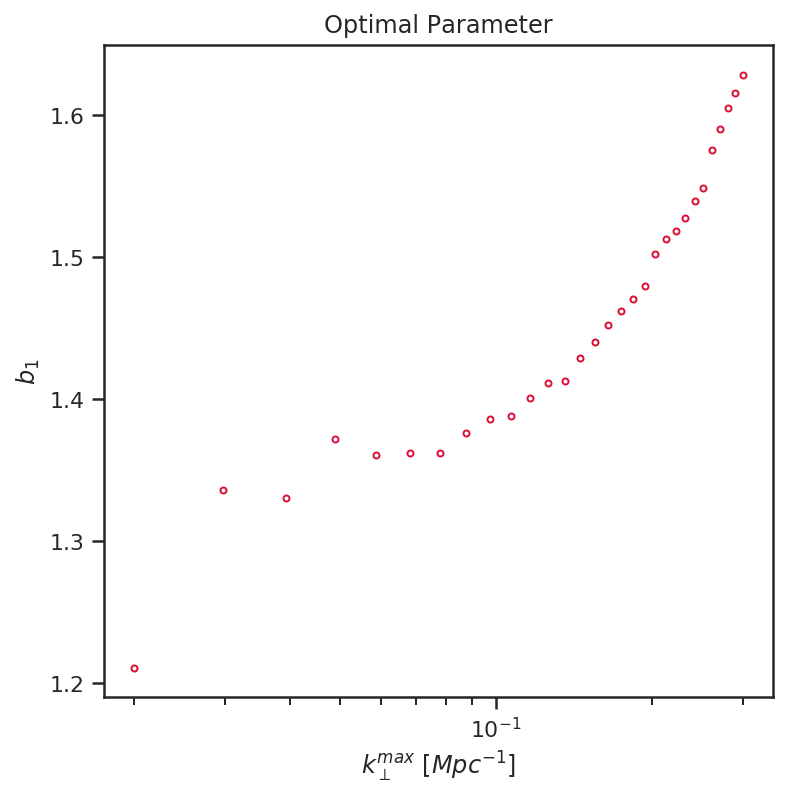

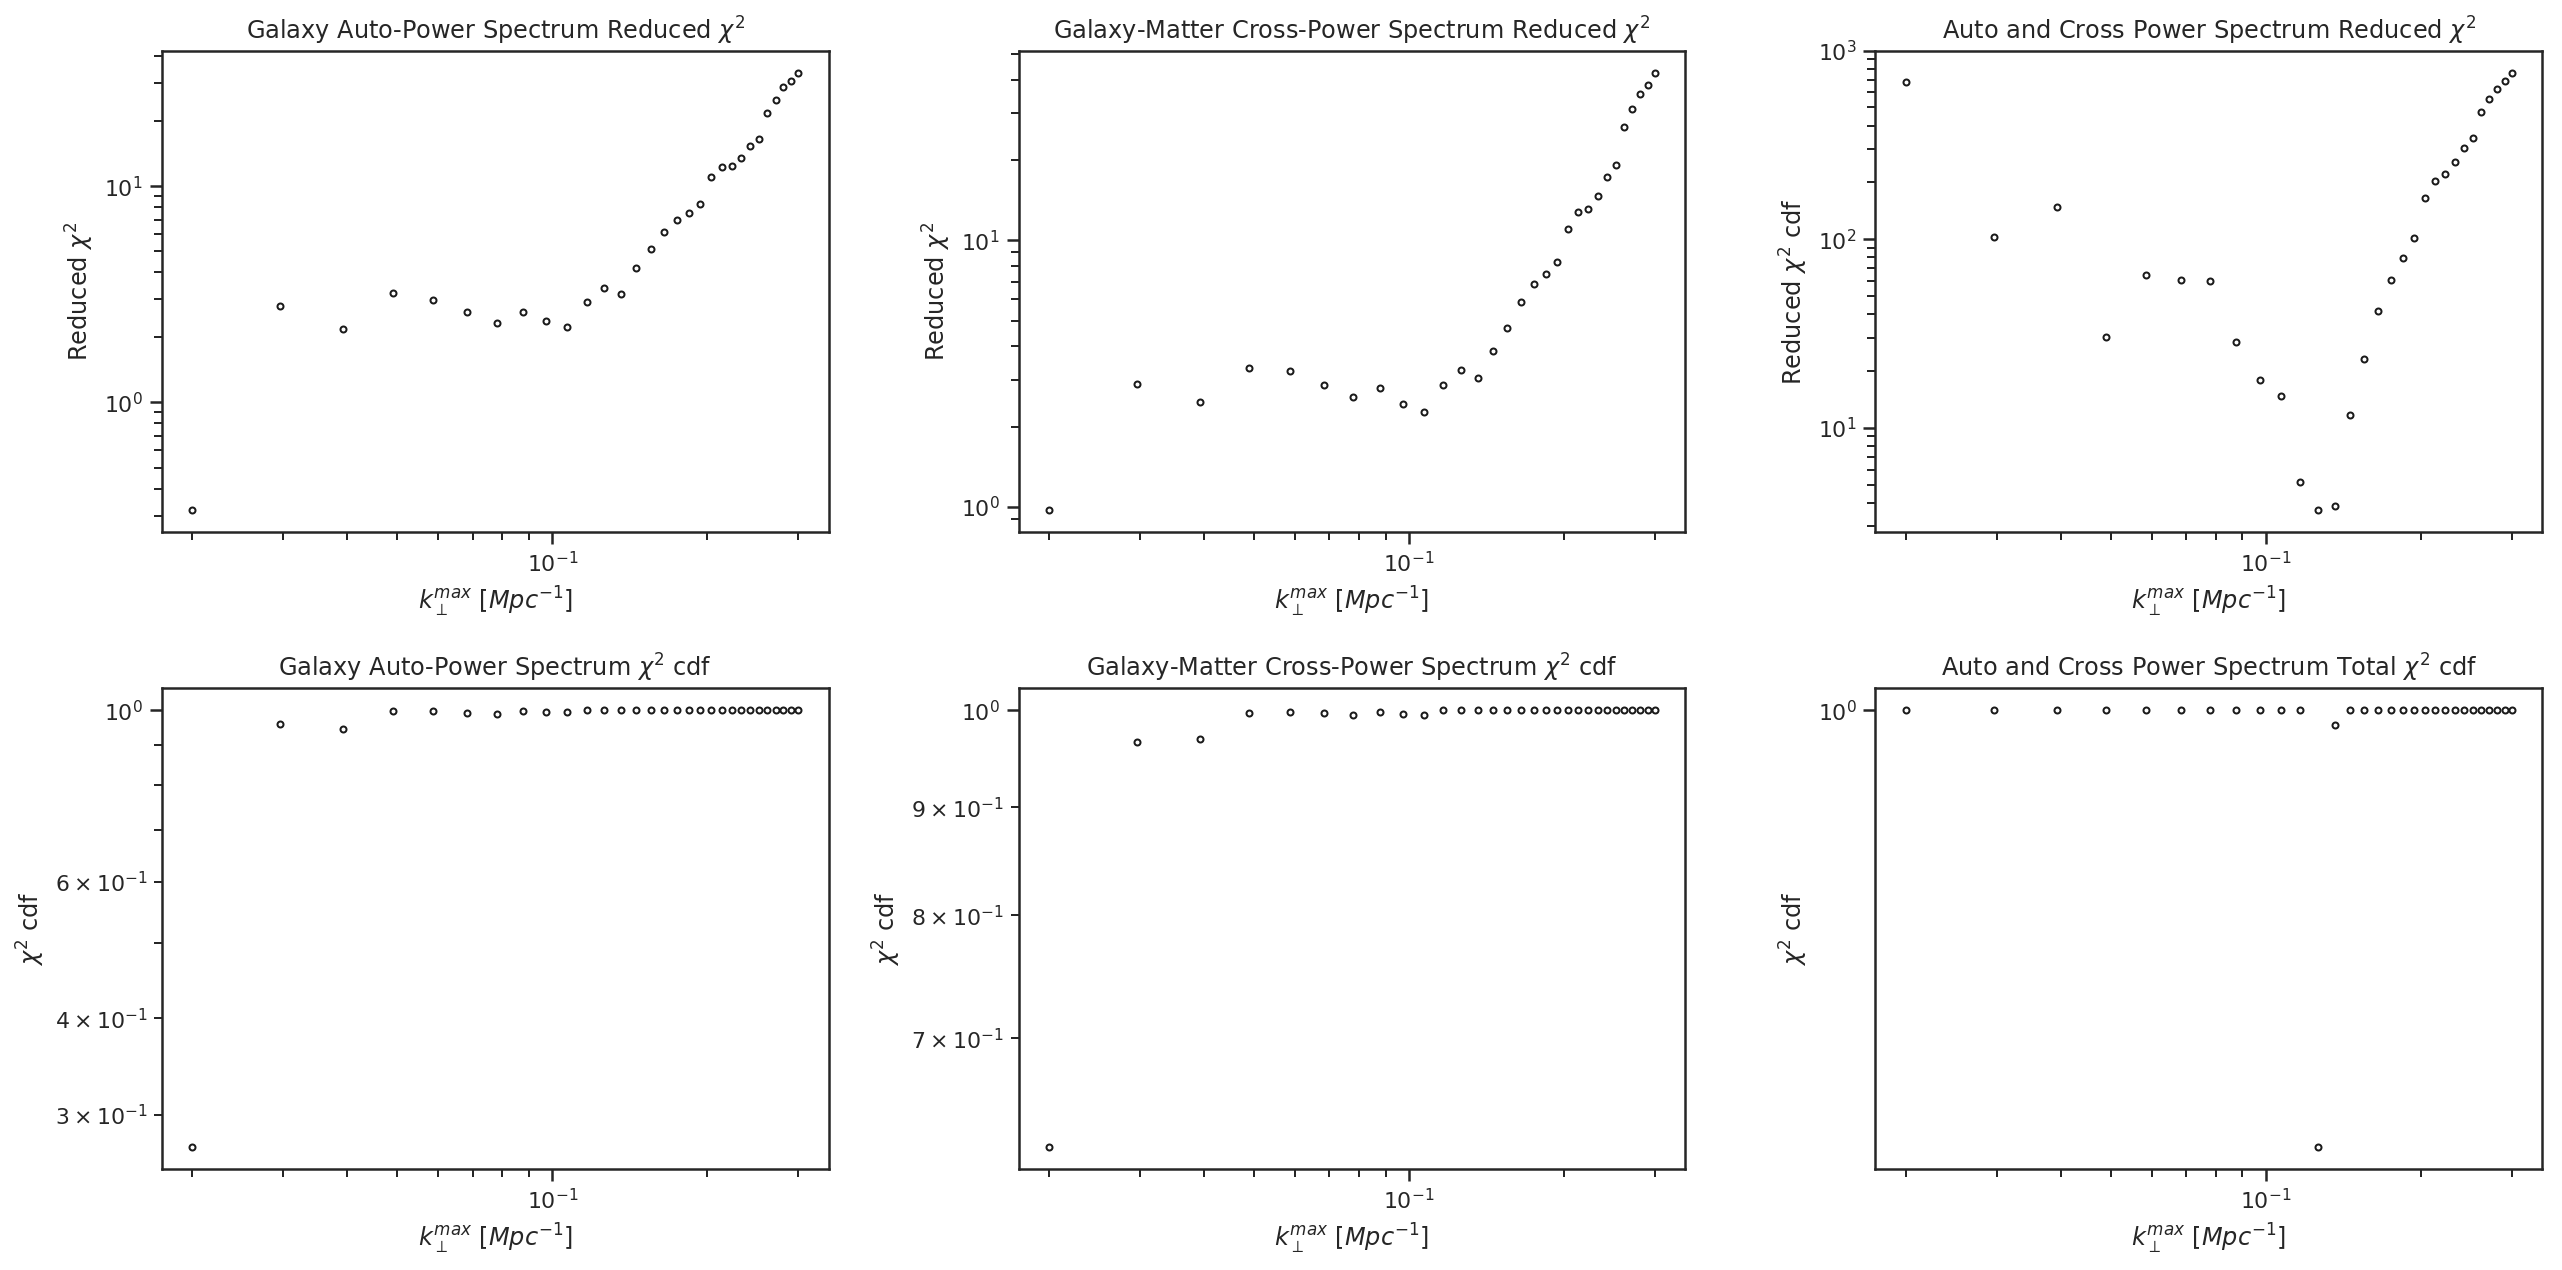

In [10]:
b_arr = b
gal_chi_sq_red, gal_chi_sq_cdf = gal_auto_chi2
gal_dm_cross_chi_sq_red, gal_dm_cross_chi_sq_cdf = gal_cross_chi2
tot_chi_sq_red, tot_chi_sq_cdf = tot_chi2

plt.figure(figsize=(6,6))

plt.plot(k_max_arr, b_arr, 'o', markersize=3, markeredgecolor="crimson",
         markerfacecolor="None", label=r"$b_1$", markeredgewidth=1)
plt.title("Optimal Parameter")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"$b_1$")
plt.xscale("log")

plt.figure(figsize = (18, 9))

plt.subplot(2, 3, 1)
plt.plot(k_max_arr, gal_chi_sq_red, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Galaxy Auto-Power Spectrum Reduced $\chi^2$")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"Reduced $\chi^2$")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2, 3, 2)
plt.plot(k_max_arr, gal_dm_cross_chi_sq_red, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Galaxy-Matter Cross-Power Spectrum Reduced $\chi^2$")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"Reduced $\chi^2$")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2, 3, 3)
plt.plot(k_max_arr, tot_chi_sq_red, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Auto and Cross Power Spectrum Reduced $\chi^2$")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"Reduced $\chi^2$ cdf")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2, 3, 4)
plt.plot(k_max_arr, gal_chi_sq_cdf, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Galaxy Auto-Power Spectrum $\chi^2$ cdf")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"$\chi^2$ cdf")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2, 3, 5)
plt.plot(k_max_arr, gal_dm_cross_chi_sq_cdf, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Galaxy-Matter Cross-Power Spectrum $\chi^2$ cdf")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"$\chi^2$ cdf")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2, 3,  6)
plt.plot(k_max_arr, tot_chi_sq_cdf, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Auto and Cross Power Spectrum Total $\chi^2$ cdf")
plt.xlabel(r"$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel(r"$\chi^2$ cdf")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

#### **Dark Matter Auto Power Spectrum and CCL Non-Linear MPS Plot:**

Plot the dark matter auto power spectrum with the CCL non-linear MPS with no bias paramaters. Also plot residuals.

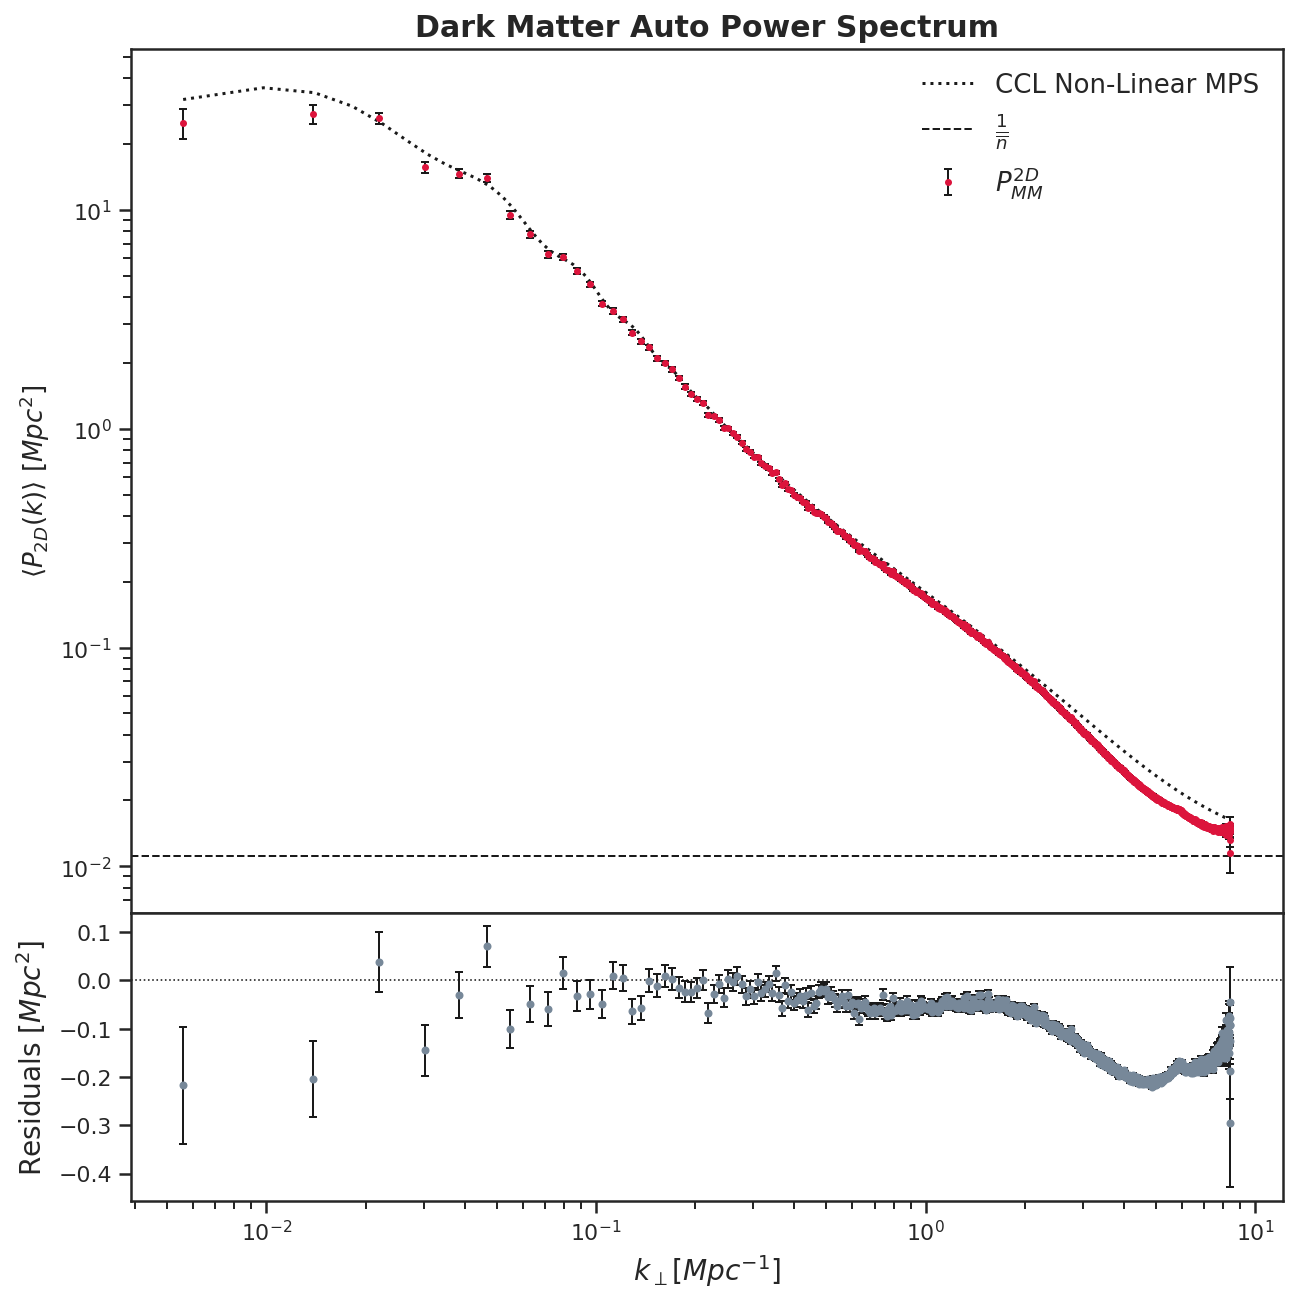

In [12]:
# Array of wavenumbers for model best-fit plots
k_thr = np.linspace(np.min(k), np.max(k), 2000)

p_dm_theory = get_pow_2d(k, 1, is_cross=False, is_linear=False,
                      n_bar=N_BAR_DM)
p_dm_err = 2*p_dm_theory**2/n_modes

# Plot data with model fit
plt.figure(figsize = (8,10))
fig_1 = plt.figure(1)
frame_1 = fig_1.add_axes((0.0, 0.3, 1.0, 0.6))

ax = plt.gca()

plt.plot(k_thr, get_pow_2d(k_thr, 1, is_cross=False, is_linear=False, 
                           n_bar=N_BAR_DM), 
         linestyle=":", color="k", label="CCL Non-Linear MPS")

plt.errorbar(k, p_dm, 
             yerr=np.sqrt(2*get_pow_2d(k, 1, is_cross=False, is_linear=False,
                                       n_bar=N_BAR_DM)**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1,label = r"$P_{MM}^{2D}$")

ax.axhline(1/N_BAR_DM, label = r"$\frac{1}{\overline{n}}$", linewidth = 1, color = "k",
           linestyle = "dashed")

plt.title("Dark Matter Auto Power Spectrum", fontweight="bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=13)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=13)
plt.legend(loc="upper right", fontsize=13, frameon=False)
plt.xscale("log")
plt.yscale("log")

limits = ax.get_xlim()

# Compute/plot residuals
frame_2 = fig_1.add_axes((0.0, 0.1, 1.0, 0.2))

ax = plt.gca()
residual  = (p_dm-p_dm_theory)/p_dm_theory

# Compute error associated with residual
sigma_t = np.sqrt(p_dm_err)

plt.errorbar(k, residual, yerr=sigma_t/p_dm_theory, marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1)

ax.axhline(0, linestyle = ":", color = "k", linewidth = 0.8)
ax.set_xlim(limits)

plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"Residuals $[Mpc^{2}]$", fontsize=14)
plt.xscale("log")

#### **One Parameter Model Particular Fit:**

Having identified the maximum values at which the fit applies in the above cells, we now analyze a particular fit. The cells simultaneously fit the one parameter model over a specified range of k values, for this example we fit:
$$k_\perp \in \ (0.0 \ \textrm{Mpc}^{-1}, 0.1 \ \textrm{Mpc}^{-1}) $$

Plots the resulting fit with the data as well as the associated residuals

In [13]:
# Fit over a specified k interval
k_min_fit = 0.00
k_max_fit = 0.1

# Get subset of galaxy auto and galaxy matter cross power spectrum data
fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
k_fit = k[fit_indices]
p_gg_fit = p_gg[fit_indices]
p_gm_fit = p_gm[fit_indices]
n_modes_fit = n_modes[fit_indices]

b_guess = 1.6

res = scipy.optimize.minimize(neg_log_like_total, b_guess, method='Nelder-Mead',
                              args=(k_fit, p_gg_fit, p_gm_fit,
                                    n_modes_fit))

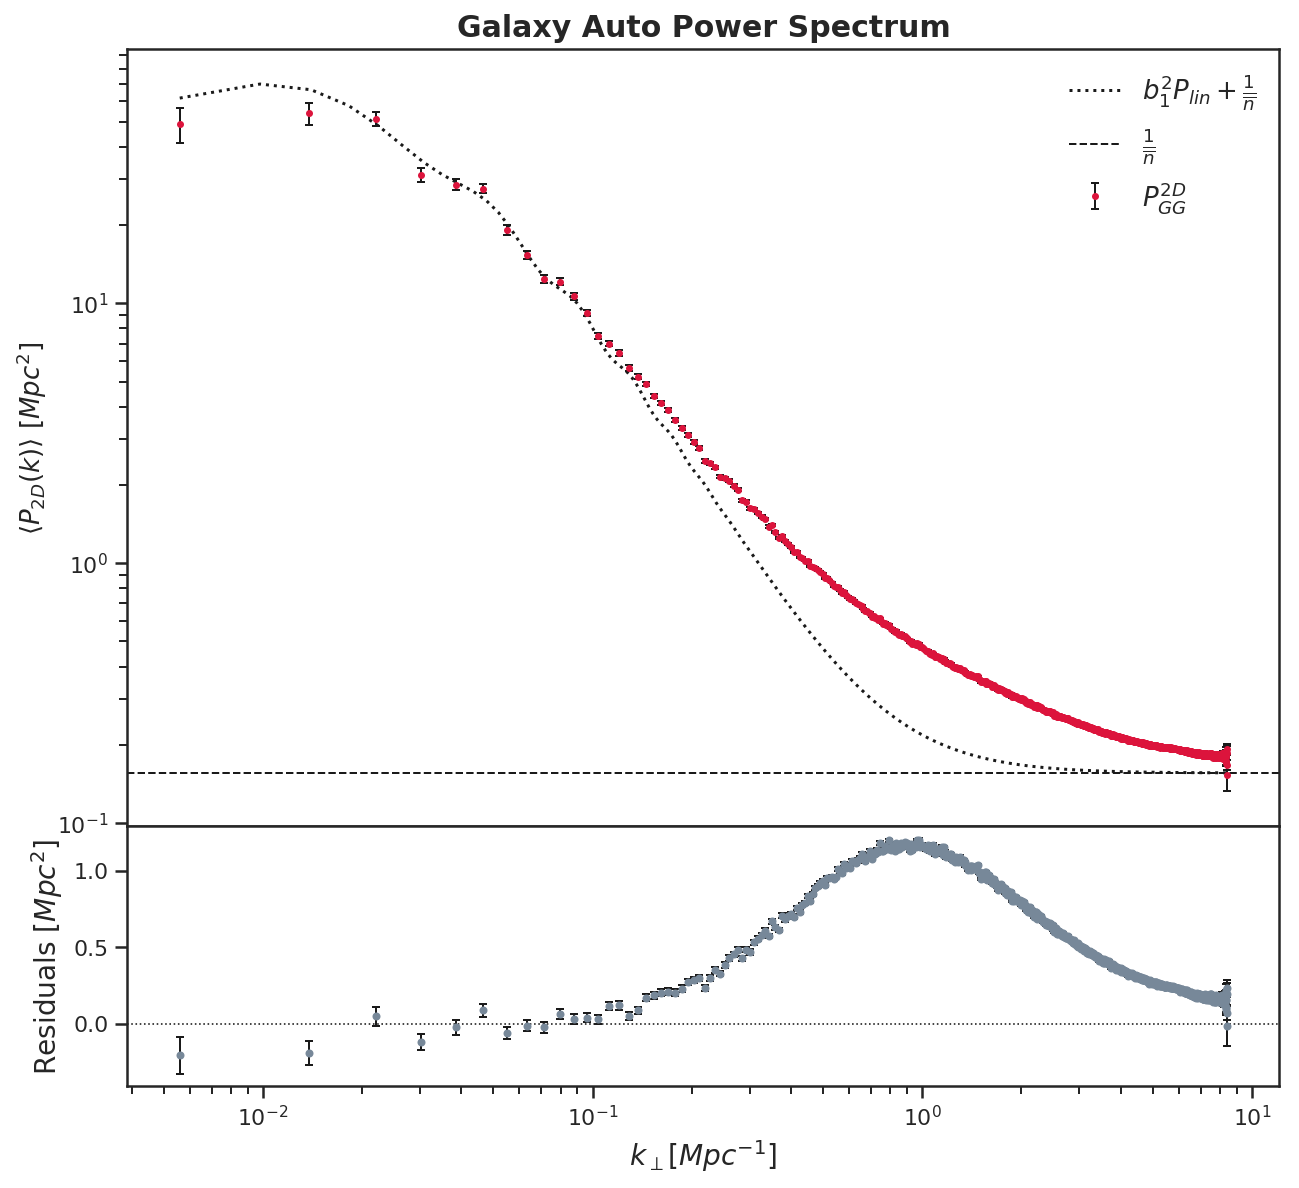

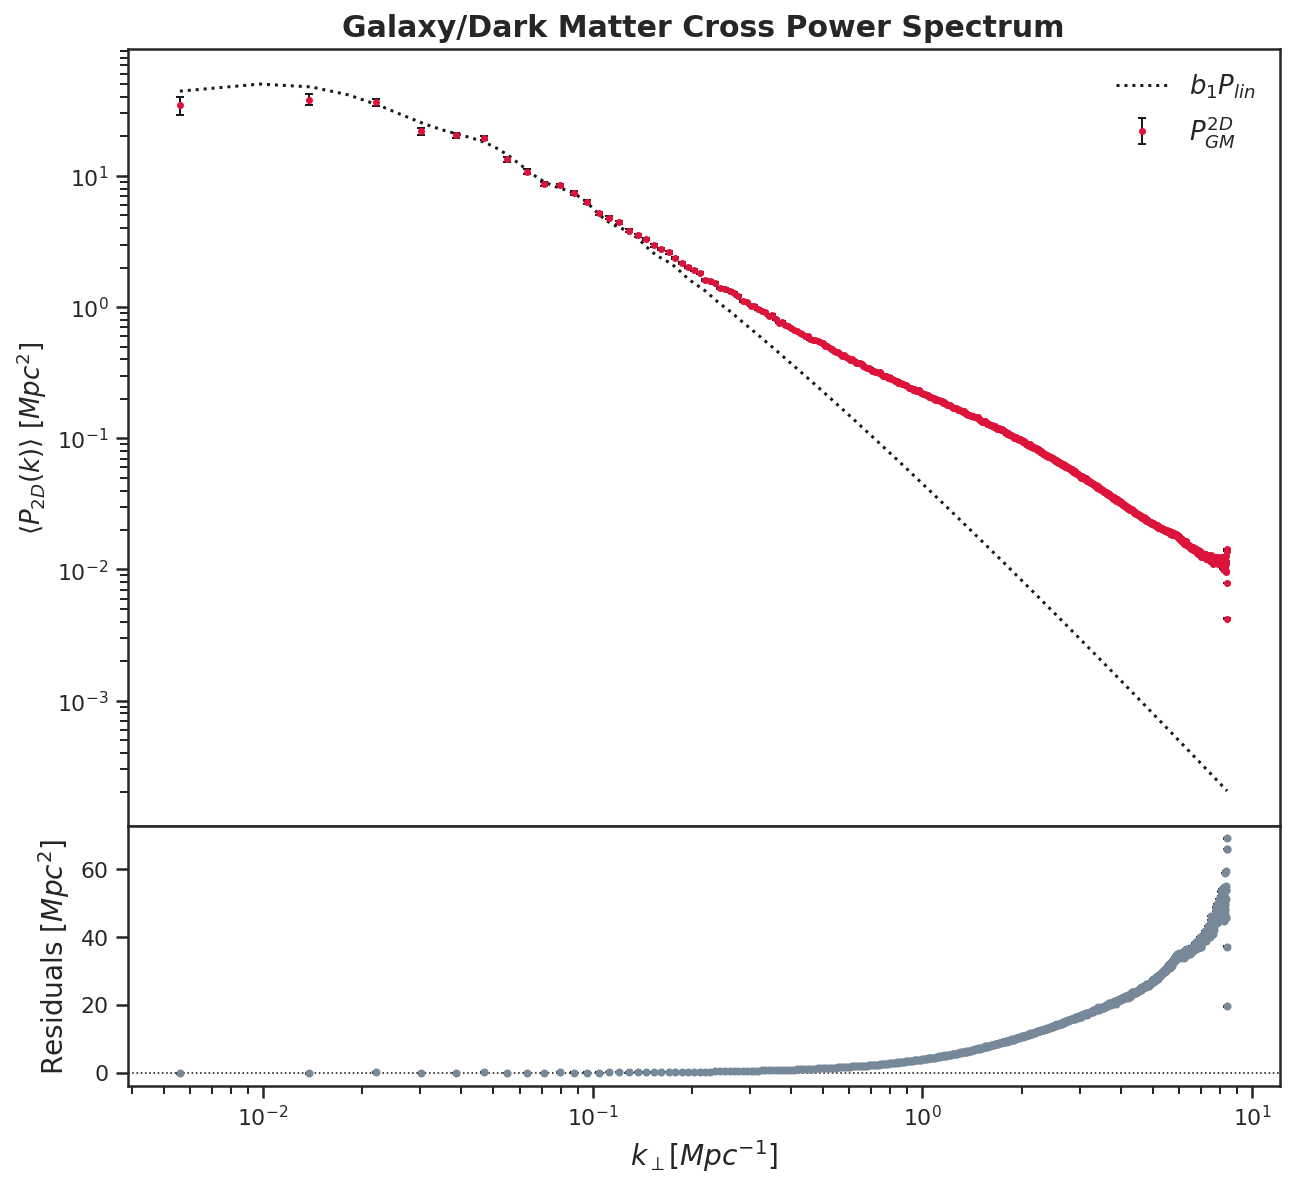

In [14]:
plt.figure(figsize = (8,9))

p_g_theory = get_pow_2d(k, res.x, is_cross=False, is_linear=True, 
                        n_bar=N_BAR_G)
p_g_err = 2*p_g_theory**2/n_modes

fig_1 = plt.figure(1)
frame_1 = fig_1.add_axes((0.0, 0.3, 1.0, 0.6))

ax = plt.gca()

plt.plot(k_thr, get_pow_2d(k_thr, res.x, is_cross=False, is_linear=True,
                           n_bar=N_BAR_G), 
         linestyle=":", color="k", 
         label=r"$b_1^2P_{lin}+\frac{1}{\overline{n}}$")

plt.errorbar(k, p_gg, 
             yerr=np.sqrt(2*get_pow_2d(k, res.x, is_cross=False, is_linear=True,
                                       n_bar=N_BAR_G)**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1,label = r"$P_{GG}^{2D}$")

ax.axhline(1/N_BAR_G, label = r"$\frac{1}{\overline{n}}$", linewidth = 1, color = "k",
           linestyle = "dashed")

plt.title("Galaxy Auto Power Spectrum", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=13)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=13)
plt.legend(loc="upper right", fontsize=13, frameon=False)
plt.xscale("log")
plt.yscale("log")
limits = ax.get_xlim()

# Compute/plot residuals
frame_2 = fig_1.add_axes((0.0, 0.1, 1.0, 0.2))

ax = plt.gca()
residual  = (p_gg-p_g_theory)/p_g_theory

# Compute error associated with residual
sigma_t = np.sqrt(p_g_err)

plt.errorbar(k, residual, yerr=sigma_t/p_g_theory, marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1)

ax.axhline(0, linestyle = ":", color = "k", linewidth = 0.8)
ax.set_xlim(limits)

plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"Residuals $[Mpc^{2}]$", fontsize=14)
plt.xscale("log")

plt.show()

# Cross Power Spectrum Plot

plt.figure(figsize = (8,9))

p_gm_theory = get_pow_2d(k, res.x, is_cross=True, is_linear=True,
                         n_bar=None)
p_gm_err = 2*p_gm_theory**2/n_modes

fig_1 = plt.figure(1)
frame_1 = fig_1.add_axes((0.0, 0.3, 1.0, 0.6))

ax = plt.gca()

plt.plot(k_thr, get_pow_2d(k_thr, res.x, is_cross=True, is_linear=True,
                           n_bar=None), 
         linestyle=":", color="k", 
         label=r"$b_1P_{lin}$")

plt.errorbar(k, p_gm, 
             yerr=np.sqrt(2*get_pow_2d(k, res.x, is_cross=True, is_linear=True,
                                       n_bar=None)**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1,label = r"$P_{GM}^{2D}$")


plt.title("Galaxy/Dark Matter Cross Power Spectrum", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$",fontsize=13)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=13)
plt.legend(loc="upper right", fontsize=13, frameon=False)
plt.xscale("log")
plt.yscale("log")

limits = ax.get_xlim()

# Compute/plot residuals
frame_2 = fig_1.add_axes((0.0, 0.1, 1.0, 0.2))

ax = plt.gca()
residual  = (p_gm-p_gm_theory)/p_gm_theory

# Compute error associated with residual
sigma_t = np.sqrt(p_gm_err)

plt.errorbar(k, residual, yerr=sigma_t/p_gm_theory, marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1)

ax.axhline(0, linestyle = ":", color = "k", linewidth = 0.8)
ax.set_xlim(limits)

plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"Residuals $[Mpc^{2}]$", fontsize=14)
plt.xscale("log")

plt.show()

### **Calculate and Plot Cross Correlation Coefficient:**

Computes the cross correlation coefficient defined as: 
$$r = \frac{P_{gm}}{\sqrt{P_{gg}P_{mm}}}$$

Computes associated error term and plots coefficient.

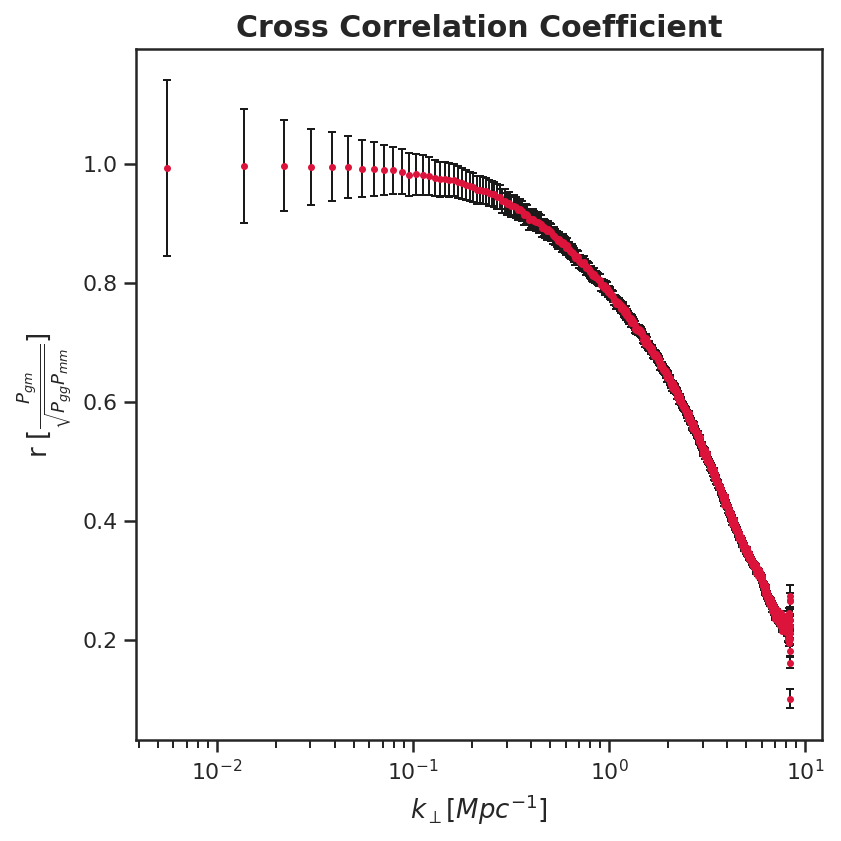

In [15]:
# Compute cross correlation coefficient
cross_corr_coef = p_gm/np.sqrt(p_gg*p_dm)

# Compute error associated with cross_corr_coeff
p_gg_err = np.sqrt(2*p_gg**2/n_modes)
p_dm_err = np.sqrt(2*p_dm**2/n_modes)
p_gm_err = np.sqrt(2*p_gm**2/n_modes)

pgg_pmm_err = np.sqrt((p_gg_err/p_gg)**2+(p_dm_err/p_dm)**2)

num_frac_err = p_gm_err/p_gm
denom_frac_err = pgg_pmm_err/2
r_frac_err = np.sqrt(num_frac_err**2+denom_frac_err**2)
r_err = cross_corr_coef*r_frac_err

# Plot results
plt.figure(figsize=(6,6))
plt.errorbar(k, cross_corr_coef, 
             yerr=r_err, 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1)

plt.xscale("log")
plt.title("Cross Correlation Coefficient", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=13)
plt.ylabel(r"r [$\frac{P_{gm}}{\sqrt{P_{gg} P_{mm}}}$]", fontsize=13)

plt.tight_layout()